In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load all datasets
file_deaths_population = "../data/processed/States_Deaths_Populations.csv"
file_poverty = "../data/processed/US_Poverty_Rate.csv"
file_income_per_capita = "../data/processed/Personal_Income_Per_Capita.csv"
file_health_care = "../data/processed/Personal_Health_Care_Per_Capita.csv"
file_median_income = "../data/processed/Median_Household_Income.csv"

# Read CSV files
df_deaths_population = pd.read_csv(file_deaths_population)
df_poverty = pd.read_csv(file_poverty)
df_income_per_capita = pd.read_csv(file_income_per_capita)
df_health_care = pd.read_csv(file_health_care)
df_median_income = pd.read_csv(file_median_income)

# Reshape "Income Per Capita" dataset to long format
df_income_per_capita_long = df_income_per_capita.melt(id_vars=["State"], var_name="Year", value_name="Income Per Capita")

# Convert "Year" to integer for consistency
df_income_per_capita_long["Year"] = df_income_per_capita_long["Year"].astype(int)

# Try merging all datasets
df_master = df_deaths_population.merge(df_poverty, on=["State", "Year"], how="left")
df_master = df_master.merge(df_income_per_capita_long, on=["State", "Year"], how="left")
df_master = df_master.merge(df_health_care, on=["State", "Year"], how="left")
df_master = df_master.merge(df_median_income, on=["State", "Year"], how="left")

# Recalculate Proportional Death Rate (deaths per 100,000 population)
df_master["Proportional Death Rate"] = (df_master["Deaths"] / df_master["Population"]) * 100000

print(df_master.head())

   Year       State  Deaths  Population  Age-adjusted Death Rate  \
0  1999     Alabama   35440     4430141                   1009.3   
1  1999      Alaska    2074      624779                    838.9   
2  1999     Arizona   31796     5023823                    818.4   
3  1999    Arkansas   22012     2651860                    975.3   
4  1999  California  186153    33499204                    802.3   

   Poverty Rate  Income Per Capita  Spending  Median Income  \
0          15.2              23296    3689.0        36251.0   
1           7.6              29941    4076.0        51396.0   
2          12.2              24866    3068.0        36995.0   
3          14.7              21842    3517.0        29682.0   
4          14.0              30529    3436.0        43629.0   

   Proportional Death Rate  
0               799.974538  
1               331.957380  
2               632.904463  
3               830.058902  
4               555.693801  


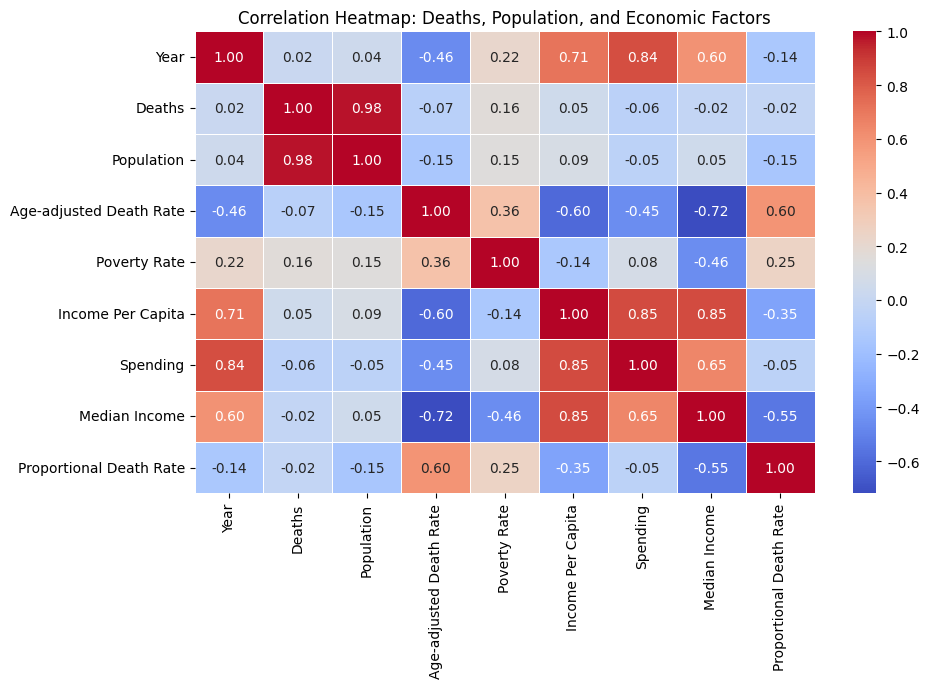

In [2]:
# Compute correlation matrix between deaths, population
numeric_df = df_master.select_dtypes(include=["number"])

# Compute correlation matrix for deaths, population, and economic factors
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Deaths, Population, and Economic Factors")
plt.show()

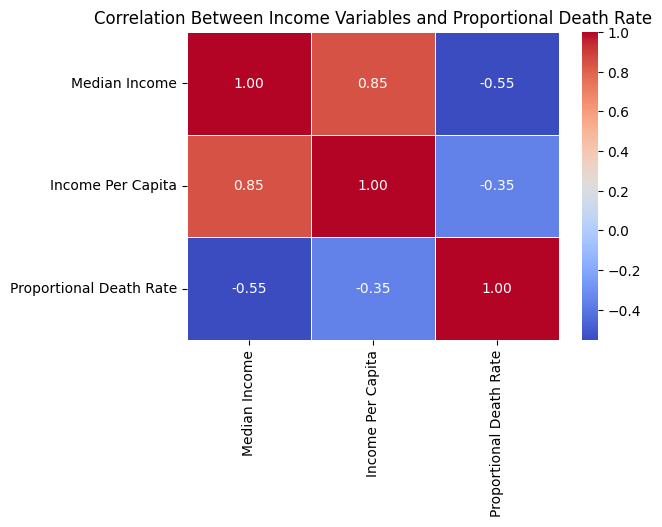

In [3]:
# Since Median Income and Income Per Capita are both income-related variables, 
# keeping both might introduce multicollinearity
# Compute correlation matrix
correlation_matrix = df_master[["Median Income", "Income Per Capita", "Proportional Death Rate"]].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Income Variables and Proportional Death Rate")
plt.show()

In [4]:
# If VIF > 5 for both Median Income and Income Per Capita, they are collinear → Drop one.
# Keep the one that has stronger correlation with Proportional Death Rate.
# Select independent variables
X = df_master[["Median Income", "Income Per Capita", "Poverty Rate", "Spending"]]

# Add constant for VIF calculation
X = sm.add_constant(X)

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             Feature        VIF
0              const  97.222991
1      Median Income   5.963317
2  Income Per Capita   8.173673
3       Poverty Rate   1.900808
4           Spending   4.266056


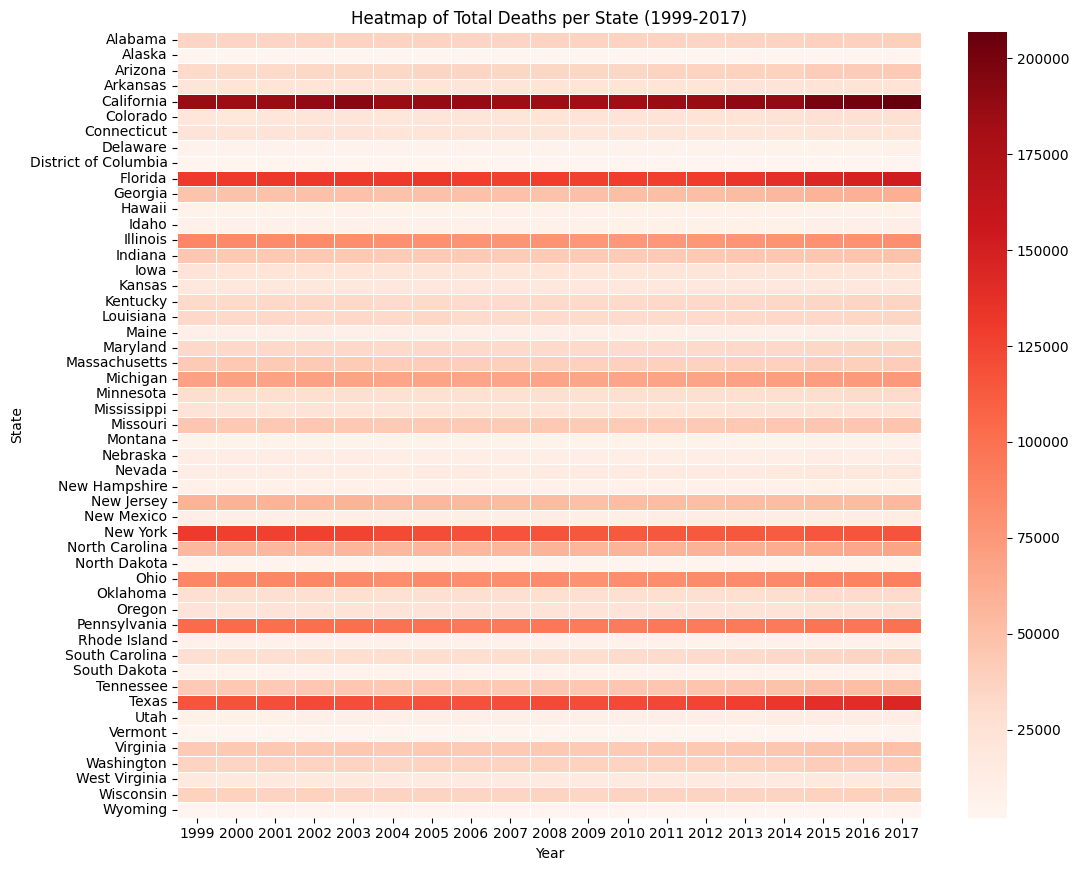

In [5]:
# Step 1: Create a heatmap for total deaths per state over time
heatmap_data_deaths = df_master.pivot(index="State", columns="Year", values="Deaths")

plt.figure(figsize=(12, len(heatmap_data_deaths) * 0.2))
sns.heatmap(heatmap_data_deaths, cmap="Reds", annot=False, linewidths=0.5)
plt.title("Heatmap of Total Deaths per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()


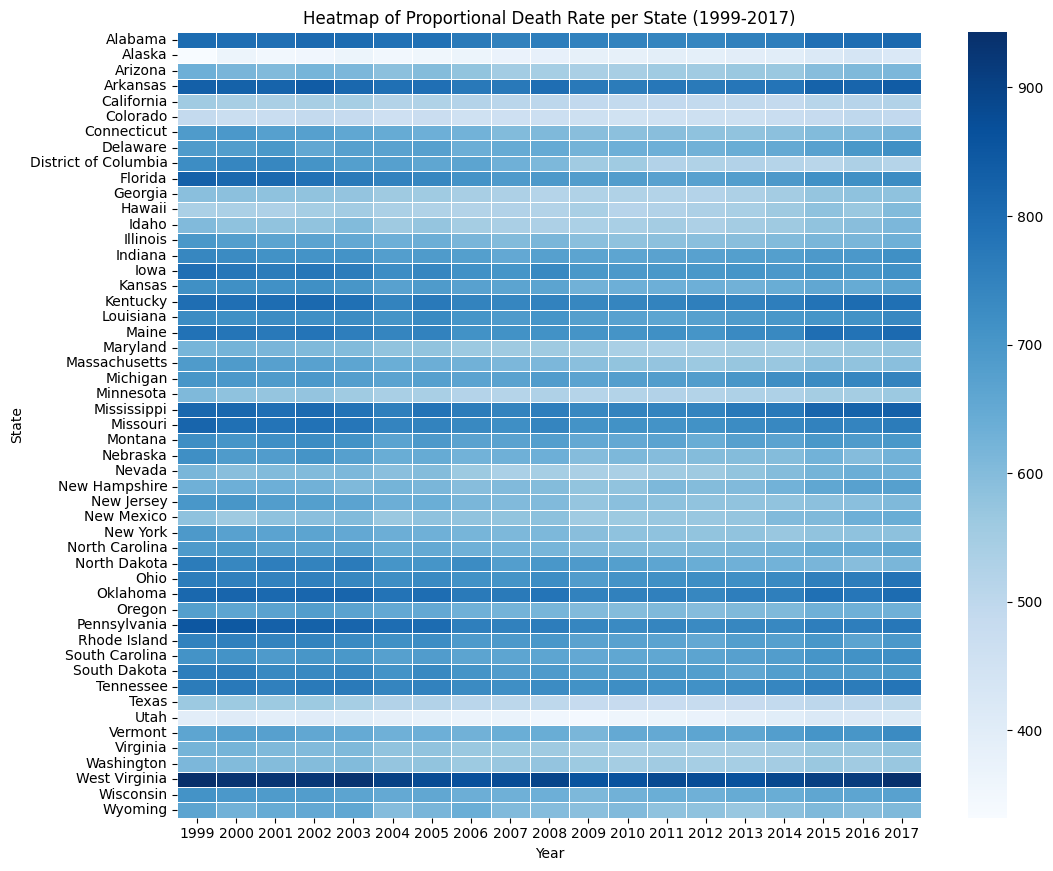

In [6]:
# Step 2: # Recalculate Proportional Death Rate (deaths per 100,000 population)
heatmap_data_proportional = df_master.pivot(index="State", columns="Year", values="Proportional Death Rate")

plt.figure(figsize=(12, len(heatmap_data_proportional) * 0.2))
sns.heatmap(heatmap_data_proportional, cmap="Blues", annot=False, linewidths=0.5)
plt.title("Heatmap of Proportional Death Rate per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

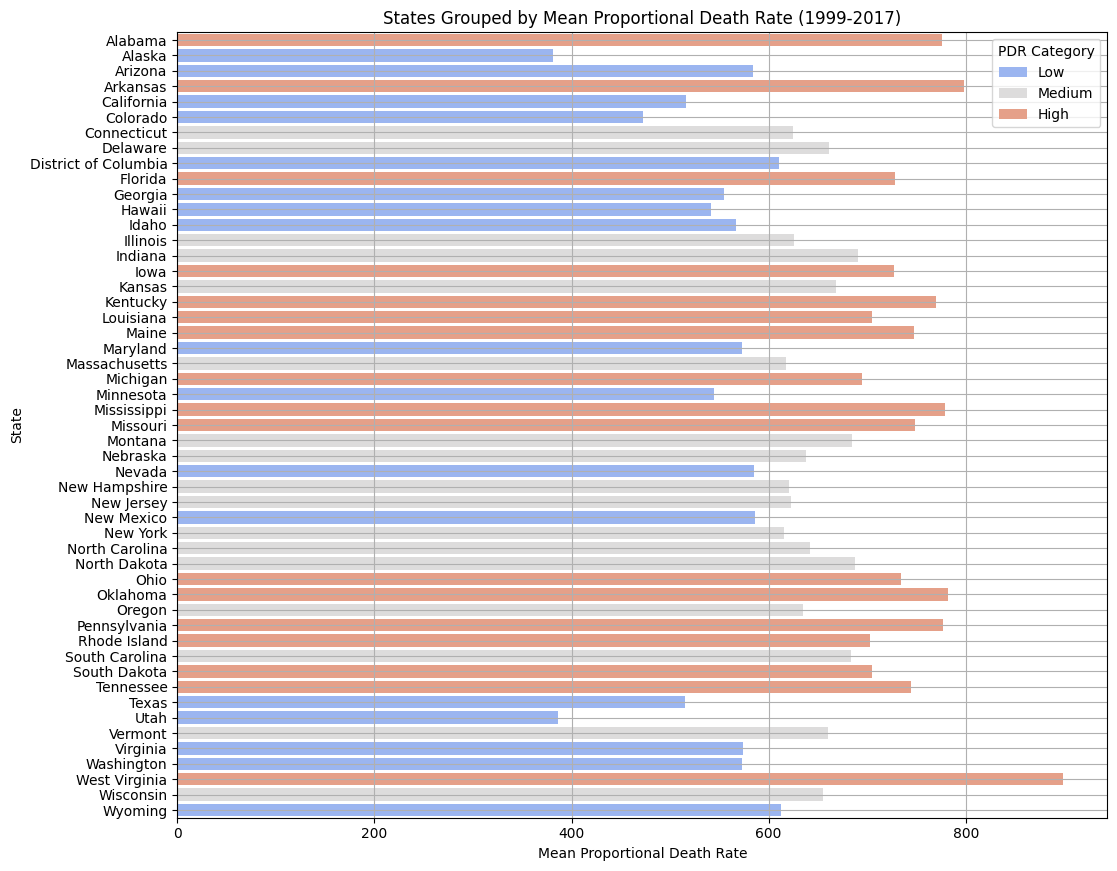

In [7]:
# Compute mean proportional death rate for each state
state_pdr_mean = df_master.groupby("State")["Proportional Death Rate"].mean()

# Define percentile-based groups
pdr_categories = pd.qcut(state_pdr_mean, q=3, labels=["Low", "Medium", "High"])

# Convert to DataFrame for plotting
pdr_category_df = pd.DataFrame({
    "State": state_pdr_mean.index,
    "Mean PDR": state_pdr_mean.values,
    "Category": pdr_categories.values  # Ensure proper alignment
})

# Plot grouped states
plt.figure(figsize=(12, len(pdr_category_df) * 0.2))
sns.barplot(x="Mean PDR", y="State", hue="Category", data=pdr_category_df, palette="coolwarm", dodge=False)
plt.title("States Grouped by Mean Proportional Death Rate (1999-2017)")
plt.xlabel("Mean Proportional Death Rate")
plt.ylabel("State")
plt.legend(title="PDR Category")
plt.grid(True)
plt.show()



        State    Mean PDR Category Region
0     Alabama  776.246988     High  South
1      Alaska  380.866256      Low   West
2     Arizona  583.998079      Low   West
3    Arkansas  798.360581     High  South
4  California  516.215764      Low   West


/tmp/ipykernel_75894/3056972598.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_pdr_counts = pdr_category_df.groupby(["Region", "Category"])["State"].count().unstack()


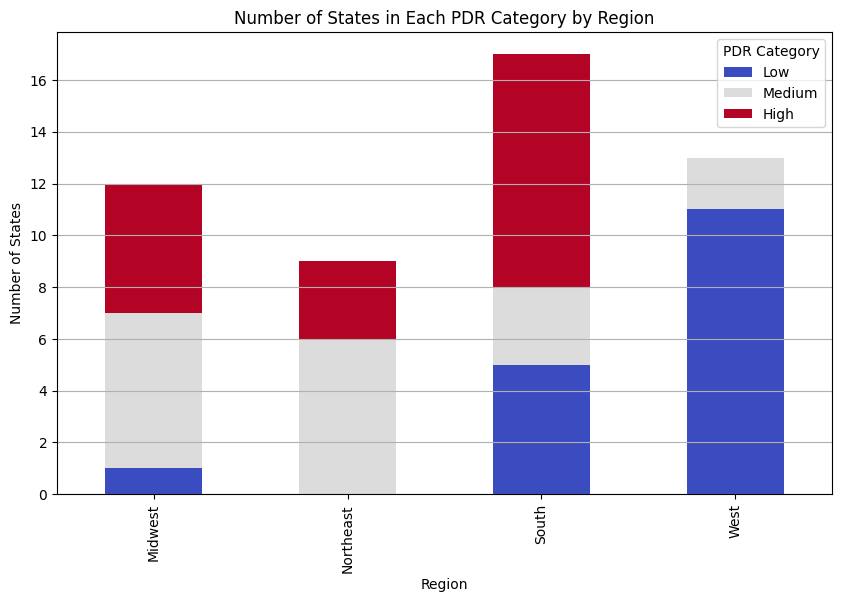

In [8]:
# Define a dictionary mapping states to regions
state_regions = {
    "Northeast": ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey", "Pennsylvania"],
    "Midwest": ["Ohio", "Indiana", "Illinois", "Michigan", "Wisconsin", "Minnesota", "Iowa", "Missouri", "North Dakota", "South Dakota", "Nebraska", "Kansas"],
    "South": ["Delaware", "Maryland", "District of Columbia", "Virginia", "West Virginia", "Kentucky", "North Carolina", "South Carolina", "Tennessee", "Georgia", "Florida",
              "Alabama", "Mississippi", "Arkansas", "Louisiana", "Oklahoma", "Texas"],
    "West": ["Montana", "Idaho", "Wyoming", "Colorado", "New Mexico", "Arizona", "Utah", "Nevada", "Washington", "Oregon", "California", "Alaska", "Hawaii"]
}

# Create a function to assign the region
def get_region(state):
    for region, states in state_regions.items():
        if state in states:
            return region
    return "Unknown"

# Apply the function to create a new column
pdr_category_df["Region"] = pdr_category_df["State"].apply(get_region)

# Update in master data frame for later use
df_master["Region"] = df_master["State"].apply(get_region)

# Display the first few rows
print(pdr_category_df.head())

# Count how many states in each region fall into Low, Medium, High PDR
region_pdr_counts = pdr_category_df.groupby(["Region", "Category"])["State"].count().unstack()

# Plot the grouped data
region_pdr_counts.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.title("Number of States in Each PDR Category by Region")
plt.xlabel("Region")
plt.ylabel("Number of States")
plt.legend(title="PDR Category")
plt.grid(axis="y")
plt.show()

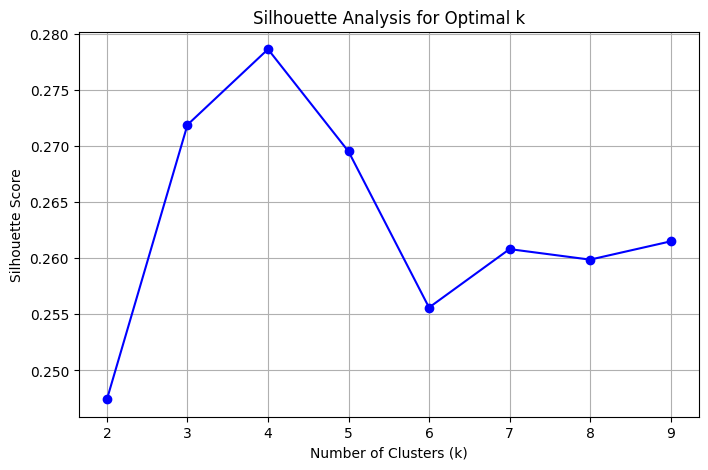

4


In [9]:
# Encode region as a numerical variable
le = LabelEncoder()
df_master["Region_Encoded"] = le.fit_transform(df_master["Region"])

# Update clustering features
clustering_features = df_master[["Proportional Death Rate", "Median Income", "Poverty Rate", "Spending", "Region_Encoded"]]

# Handle missing values by filling with the mean
clustering_features = clustering_features.fillna(clustering_features.mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)



         Proportional Death Rate  Poverty Rate  Median Income     Spending
Cluster                                                                   
0                     692.048277     10.922222   46634.662698  6016.773810
1                     725.323141     16.222932   40342.909774  6103.424812
2                     535.538524     11.641991   51880.904762  5585.341991
3                     620.324278     11.271364   60955.436364  9034.372727


<Figure size 1200x600 with 0 Axes>

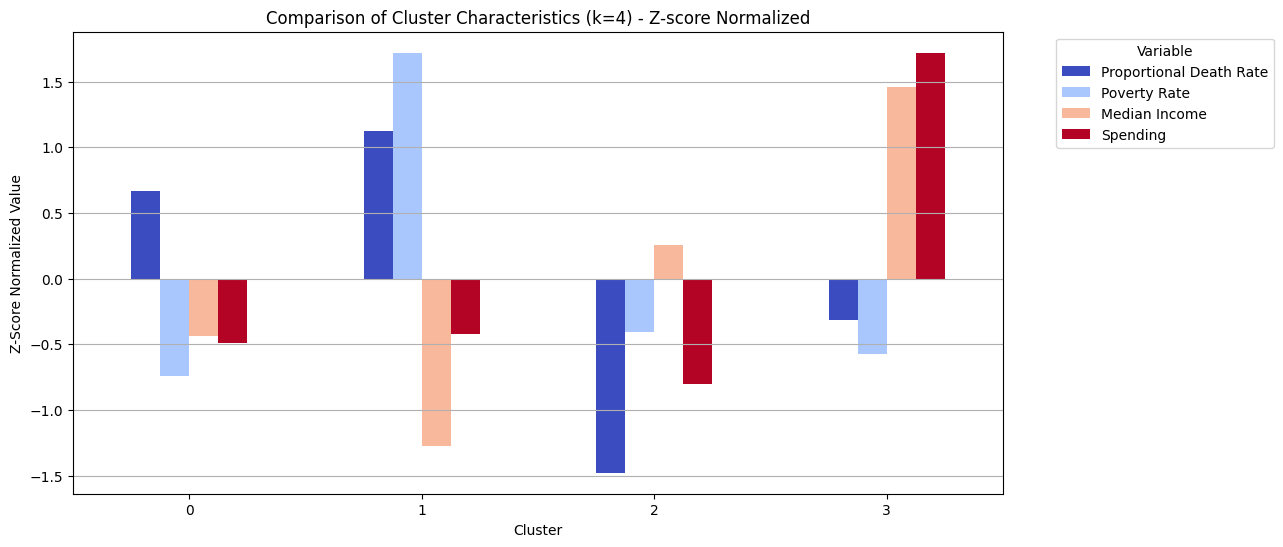

In [10]:

# Run K-Means Clustering with the optimal k = 4 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster (k=4) to interpret their meaning
cluster_characteristics_k4 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Median Income", "Spending"]
].mean()

print(cluster_characteristics_k4)

cluster_characteristics_zscore = pd.DataFrame(
    scaler.fit_transform(cluster_characteristics_k4),
    columns=cluster_characteristics_k4.columns,
    index=cluster_characteristics_k4.index
)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_zscore.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=4) - Z-score Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


         Proportional Death Rate  Poverty Rate  Median Income     Spending
Cluster                                                                   
0                     692.048277     10.922222   46634.662698  6016.773810
1                     725.323141     16.222932   40342.909774  6103.424812
2                     535.538524     11.641991   51880.904762  5585.341991
3                     620.324278     11.271364   60955.436364  9034.372727


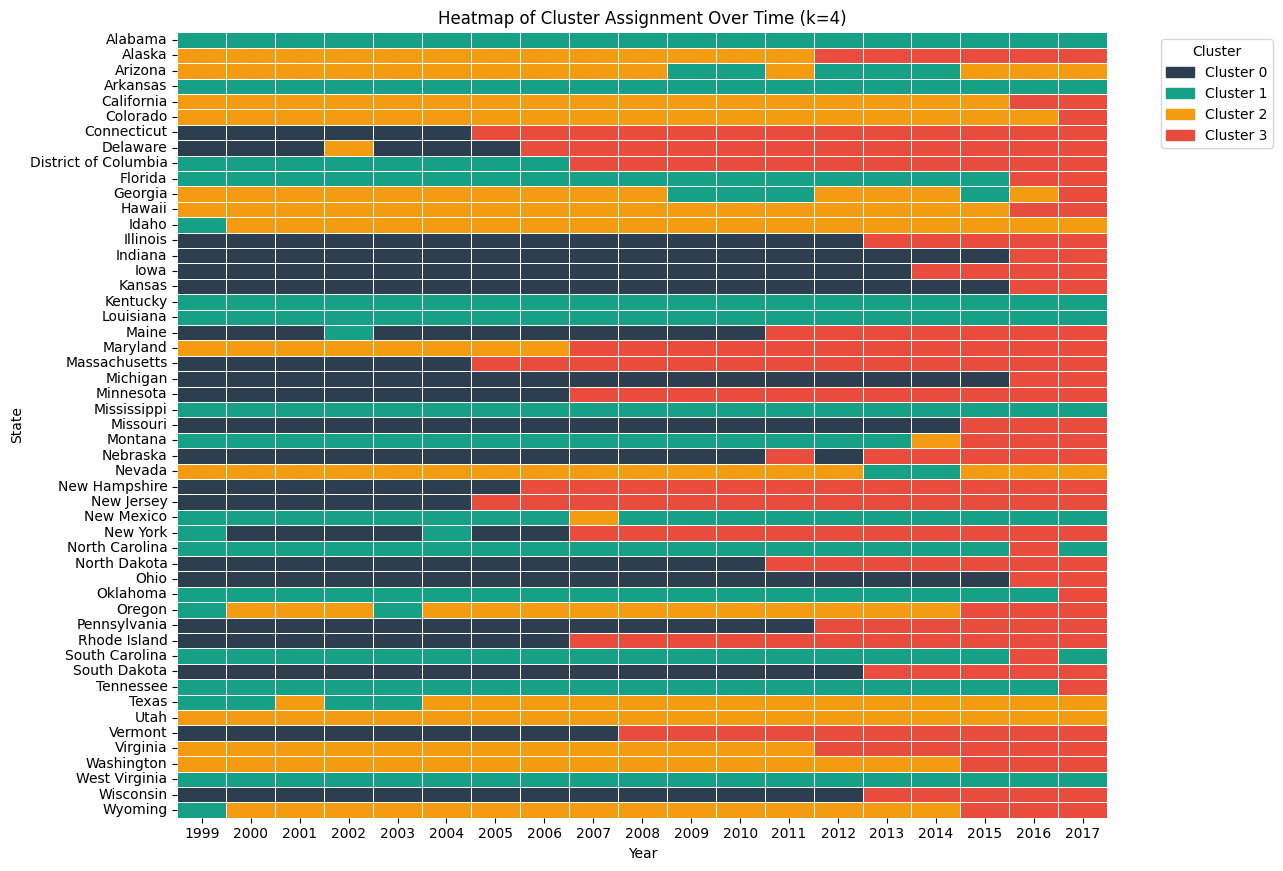

In [11]:
# Run K-Means Clustering with the optimal k = 2 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster
cluster_characteristics_k4 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Median Income", "Spending"]
].mean()

print(cluster_characteristics_k4)

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_data = df_master.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1
cluster_colors = ["#2C3E50", "#16A085", "#F39C12", "#E74C3C"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(4)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time (k=4)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()

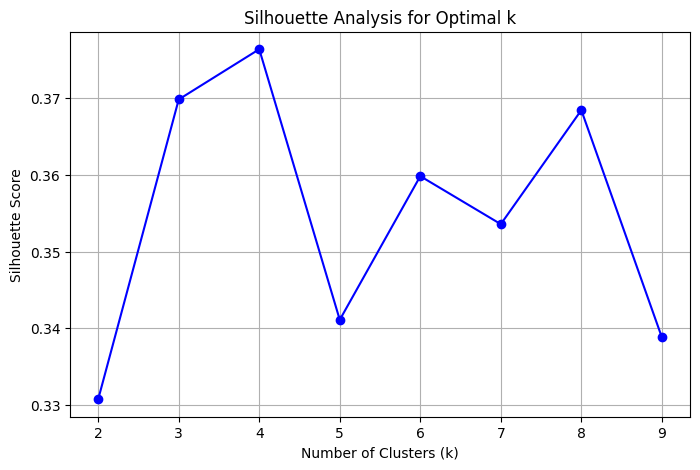

4
         Normalized Median Income  Normalized Spending  \
Cluster                                                  
0                       -0.120326             0.278208   
1                        0.354642            -0.920749   
2                       -1.170217            -0.410443   
3                        1.236467             1.336055   

         Normalized Proportional Death Rate  Normalized Poverty Rate  
Cluster                                                               
0                                  0.447450                -0.278557  
1                                 -0.959779                -0.153615  
2                                  0.861795                 1.074795  
3                                 -0.527477                -0.772627  


<Figure size 1200x600 with 0 Axes>

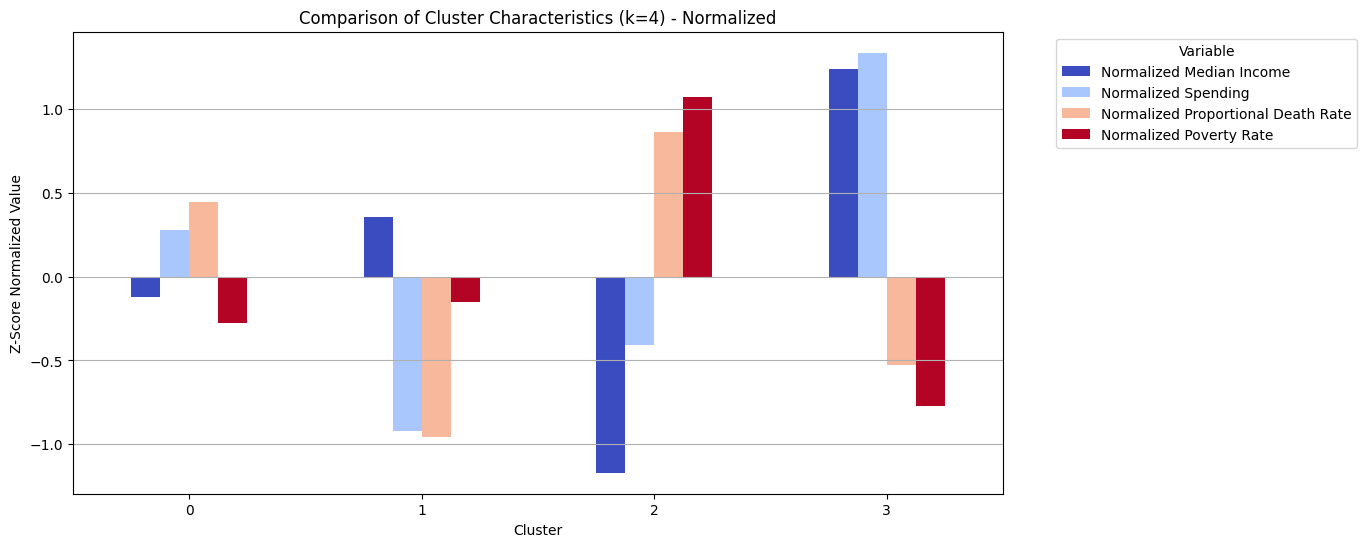

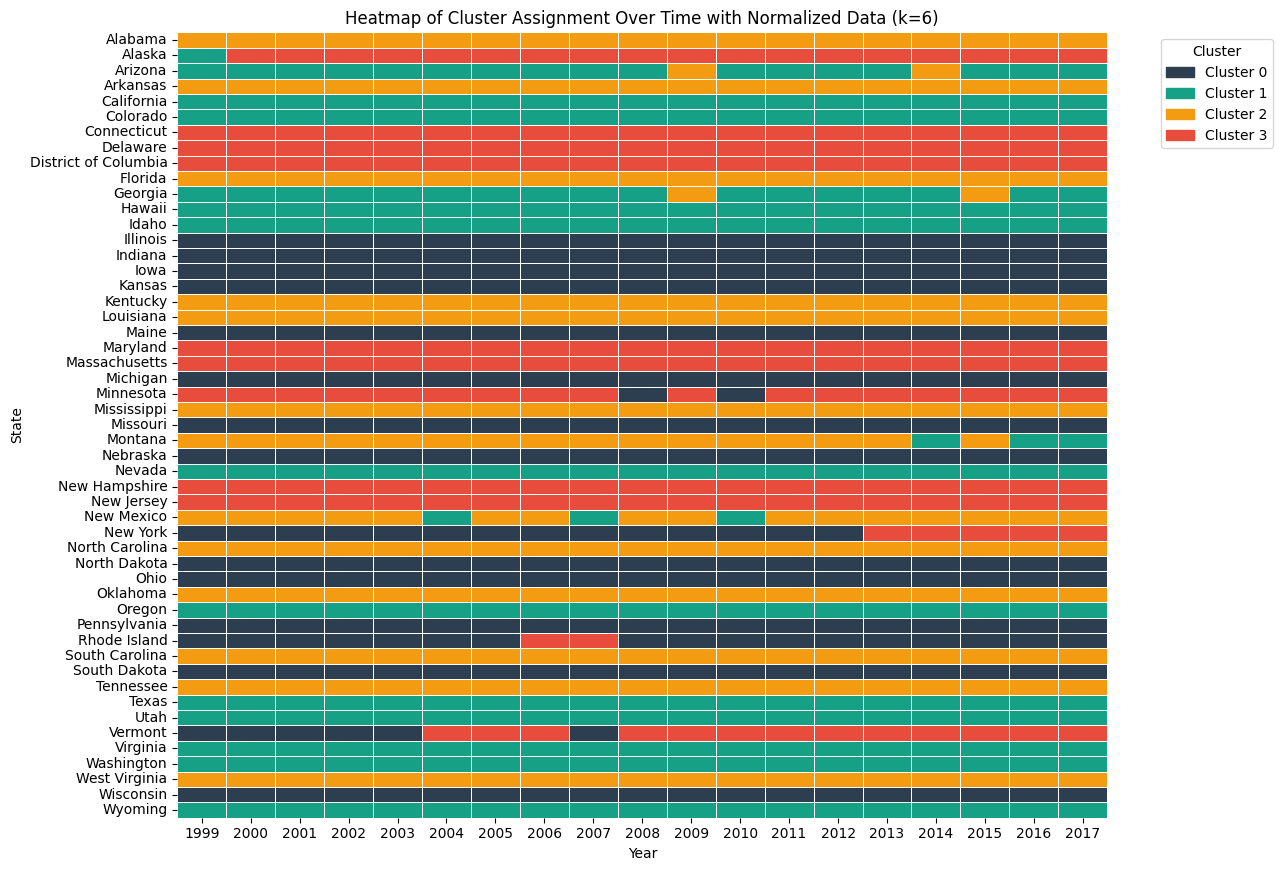

In [12]:
# Normalize selected columns by year
variables_to_normalize = ["Median Income", "Spending", "Proportional Death Rate", "Poverty Rate"]
df_normalized = df_master.copy()

for var in variables_to_normalize:
    df_normalized[f"Normalized {var}"] = df_normalized.groupby("Year")[var].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    
# Select the normalized variables for clustering
normalized_features = [
    "Normalized Median Income",
    "Normalized Spending",
    "Normalized Proportional Death Rate",
    "Normalized Poverty Rate",
]
    
scaler = StandardScaler()
scaled_normalized_features = scaler.fit_transform(df_normalized[normalized_features])
scaled_normalized_features = np.column_stack((scaled_normalized_features, df_master["Region_Encoded"]))

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_normalized_features)
    silhouette_avg = silhouette_score(scaled_normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)

# Re-run K-Means clustering with k=4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(scaled_normalized_features)


# Display the new cluster characteristics
cluster_characteristics_normalized = df_normalized.groupby("Cluster")[
    normalized_features
].mean()

print(cluster_characteristics_normalized)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_normalized.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=4) - Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_normalized_data = df_normalized.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1, 2, 3
cluster_colors = ["#2C3E50", "#16A085", "#F39C12", "#E74C3C"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_normalized_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_normalized_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(4)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time with Normalized Data (k=6)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()

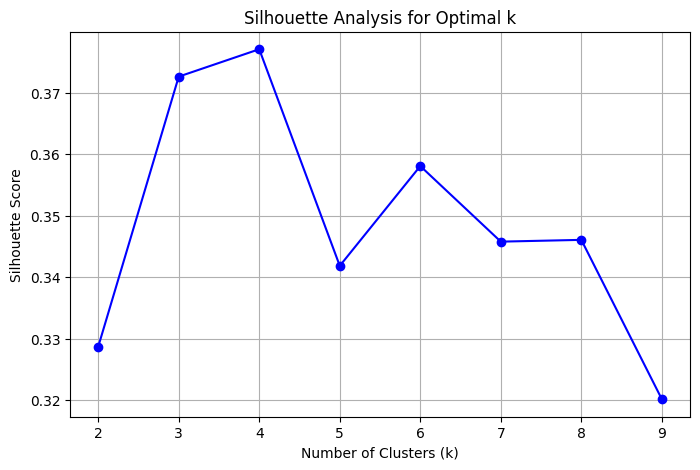

4
         Normalized Median Income  Normalized Spending  \
Cluster                                                  
0                       -0.122409             0.268060   
1                       -1.087970            -0.379849   
2                        0.297006            -0.807508   
3                        1.295434             1.218955   

         Normalized Age-adjusted Death Rate  Normalized Poverty Rate  
Cluster                                                               
0                                 -0.199156                -0.274850  
1                                  1.267100                 1.169112  
2                                 -0.621530                -0.213902  
3                                 -0.596887                -0.902485  


<Figure size 1200x600 with 0 Axes>

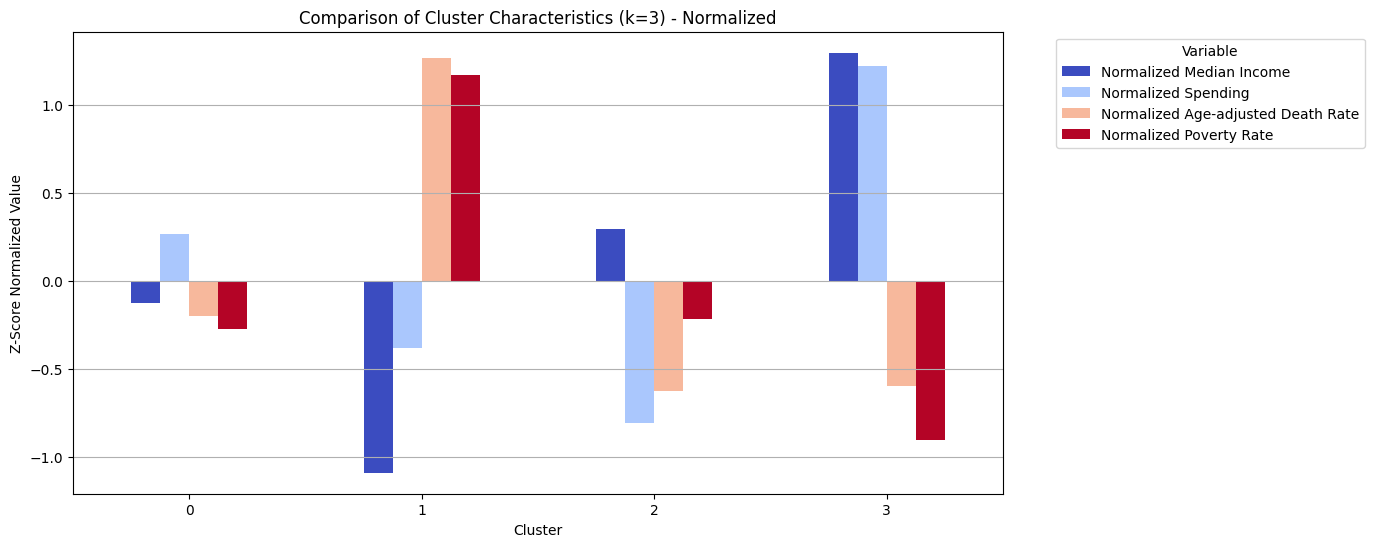

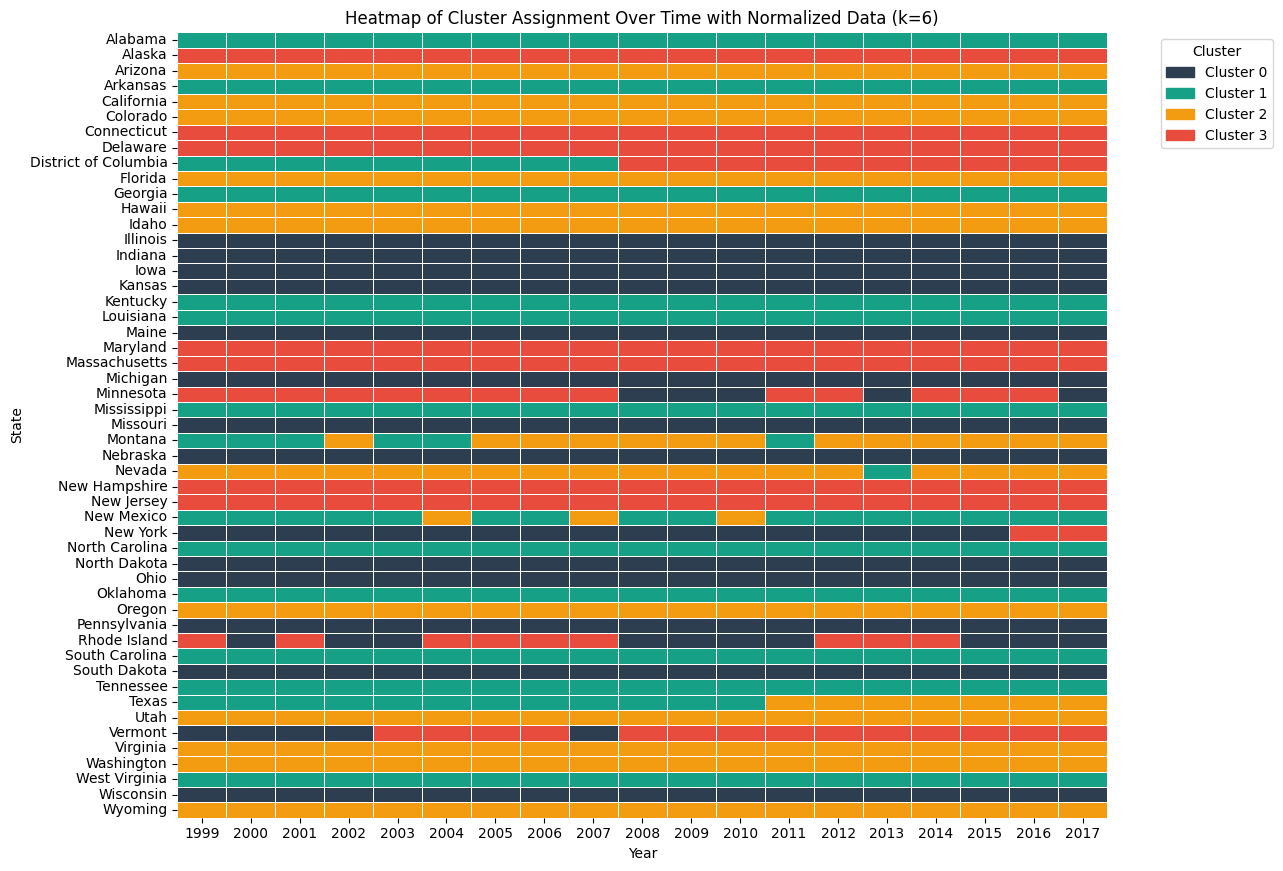

In [13]:
# use Age-adjusted death instead of proportional death
# Normalize selected columns by year
variables_to_normalize = ["Median Income", "Spending", "Age-adjusted Death Rate", "Poverty Rate"]
df_normalized = df_master.copy()

for var in variables_to_normalize:
    df_normalized[f"Normalized {var}"] = df_normalized.groupby("Year")[var].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    
# Select the normalized variables for clustering
normalized_features = [
    "Normalized Median Income",
    "Normalized Spending",
    "Normalized Age-adjusted Death Rate",
    "Normalized Poverty Rate",
]
    
scaler = StandardScaler()
scaled_normalized_features = scaler.fit_transform(df_normalized[normalized_features])
scaled_normalized_features = np.column_stack((scaled_normalized_features, df_master["Region_Encoded"]))

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_normalized_features)
    silhouette_avg = silhouette_score(scaled_normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)

# Re-run K-Means clustering with k=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(scaled_normalized_features)


# Display the new cluster characteristics
cluster_characteristics_normalized = df_normalized.groupby("Cluster")[
    normalized_features
].mean()

print(cluster_characteristics_normalized)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_normalized.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_normalized_data = df_normalized.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1, 2, 3
cluster_colors = ["#2C3E50", "#16A085", "#F39C12", "#E74C3C"] # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_normalized_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_normalized_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(4)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time with Normalized Data (k=6)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()

In [14]:
# See if policy change will impact death rate pattern
# Medicaid expansion in 2014 
# The DiD coefficient tells us the impact of Medicaid expansion on death rates.
df_master["Post_2014"] = (df_master["Year"] >= 2014).astype(int)  # 1 if year is 2014 or later

# Define treatment states (those that expanded Medicaid)
medicaid_expansion_states = [
    "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Hawaii",
    "Illinois", "Iowa", "Kentucky", "Maryland", "Massachusetts", "Minnesota",
    "Nevada", "New Jersey", "New Mexico", "New York", "North Dakota", "Ohio",
    "Oregon", "Rhode Island", "Vermont", "Washington", "West Virginia", "District of Columbia"
]

df_master["Treatment"] = df_master["State"].isin(medicaid_expansion_states).astype(int)

# Interaction term for DiD
df_master["DiD"] = df_master["Treatment"] * df_master["Post_2014"]

# Fit a Difference-in-Differences model
model = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD", data=df_master).fit()

# Display results
print(model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.157
Model:                                      OLS   Adj. R-squared:                  0.155
Method:                           Least Squares   F-statistic:                     60.01
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):           1.41e-35
Time:                                  21:55:28   Log-Likelihood:                -5732.9
No. Observations:                           969   AIC:                         1.147e+04
Df Residuals:                               965   BIC:                         1.149e+04
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [15]:
model = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + Q('Median Income') + Q('Poverty Rate') + Spending", data=df_master).fit()
print(model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.545
Model:                                      OLS   Adj. R-squared:                  0.542
Method:                           Least Squares   F-statistic:                     191.8
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):          1.49e-160
Time:                                  21:55:28   Log-Likelihood:                -5434.5
No. Observations:                           969   AIC:                         1.088e+04
Df Residuals:                               962   BIC:                         1.092e+04
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [16]:
# one-year lag
df_master["DiD_Lag1"] = df_master["DiD"].shift(1)
model_lag1 = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + DiD_Lag1 + Q('Median Income') + Q('Poverty Rate') + Spending", data=df_master).fit()
print(model_lag1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.544
Model:                                      OLS   Adj. R-squared:                  0.541
Method:                           Least Squares   F-statistic:                     163.9
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):          4.27e-159
Time:                                  21:55:28   Log-Likelihood:                -5427.4
No. Observations:                           968   AIC:                         1.087e+04
Df Residuals:                               960   BIC:                         1.091e+04
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [17]:
# two-year lag
df_master["DiD_Lag2"] = df_master["DiD"].shift(2)
model_lag2 = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + DiD_Lag1 + DiD_Lag2 + Q('Median Income') + Q('Poverty Rate') + Spending", data=df_master).fit()
print(model_lag2.summary())


                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.547
Model:                                      OLS   Adj. R-squared:                  0.543
Method:                           Least Squares   F-statistic:                     144.3
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):          9.05e-159
Time:                                  21:55:28   Log-Likelihood:                -5419.9
No. Observations:                           967   AIC:                         1.086e+04
Df Residuals:                               958   BIC:                         1.090e+04
Df Model:                                     8                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [18]:
# Use a Moving Average or Cumulative Policy Impact
df_master["DiD_Cumulative"] = df_master["DiD"].rolling(window=3, min_periods=1).mean()
model_cumulative = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + DiD_Cumulative + Q('Median Income') + Q('Poverty Rate') + Spending", data=df_master).fit()
print(model_cumulative.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.545
Model:                                      OLS   Adj. R-squared:                  0.542
Method:                           Least Squares   F-statistic:                     164.4
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):          1.69e-159
Time:                                  21:55:28   Log-Likelihood:                -5434.3
No. Observations:                           969   AIC:                         1.088e+04
Df Residuals:                               961   BIC:                         1.092e+04
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [19]:
# Try a Fixed Effects or Random Effects Model
model_fe = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + C(State)", data=df_master).fit()
print(model_fe.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.785
Model:                                      OLS   Adj. R-squared:                  0.773
Method:                           Least Squares   F-statistic:                     64.31
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):          1.90e-267
Time:                                  21:55:29   Log-Likelihood:                -5071.0
No. Observations:                           969   AIC:                         1.025e+04
Df Residuals:                               916   BIC:                         1.051e+04
Df Model:                                    52                                         
Covariance Type:                      nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------

In [ ]:
# add C(Year)
model_fe_2 = smf.ols("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + DiD_Lag1 + DiD_Lag2 + C(State) + C(Year)", data=df_master).fit()
print(model_fe_2.summary())

/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       1.000
Model:                                      OLS   Adj. R-squared:                    nan
Method:                           Least Squares   F-statistic:                       nan
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):                nan
Time:                                  21:57:40   Log-Likelihood:                 23740.
No. Observations:                           967   AIC:                        -4.555e+04
Df Residuals:                                 0   BIC:                        -4.083e+04
Df Model:                                   966                                         
Covariance Type:                      nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      

In [27]:
model_re = MixedLM.from_formula("Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD", 
                                groups="State", data=df_master).fit()
print(model_re.summary())

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Age-adjusted Death Rate')
No. Observations: 969     Method:             REML                        
No. Groups:       51      Scale:              2175.2629                   
Min. group size:  19      Log-Likelihood:     -5185.7937                  
Max. group size:  19      Converged:          Yes                         
Mean group size:  19.0                                                    
-----------------------------------------------------------------------------
               Coef.      Std.Err.       z       P>|z|     [0.025      0.975]
-----------------------------------------------------------------------------
Intercept      838.850      15.247     55.016    0.000     808.966    868.734
Treatment      -58.812      22.227     -2.646    0.008    -102.376    -15.249
Post_2014      -52.704       5.051    -10.434    0.000     -62.604    -42.804
DiD            -11.666    

In [30]:
df_master["High_Income"] = (df_master["Median Income"] > df_master["Median Income"].median()).astype(int)

model_interaction = MixedLM.from_formula(
    "Q('Age-adjusted Death Rate') ~ Treatment + Post_2014 + DiD + DiD * High_Income", 
    groups="State", data=df_master).fit()
print(model_interaction.summary())


                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Age-adjusted Death Rate')
No. Observations: 969     Method:             REML                        
No. Groups:       51      Scale:              1757.9435                   
Min. group size:  19      Log-Likelihood:     -5073.9560                  
Max. group size:  19      Converged:          Yes                         
Mean group size:  19.0                                                    
----------------------------------------------------------------------------
                    Coef.     Std.Err.      z      P>|z|    [0.025    0.975]
----------------------------------------------------------------------------
Intercept           855.102     13.174    64.907   0.000   829.281   880.923
Treatment           -41.323     19.175    -2.155   0.031   -78.907    -3.740
Post_2014           -21.863      4.979    -4.391   0.000   -31.622   -12.103
DiD                  -8.003     

In [32]:
df_master["Years_Since_Treatment"] = df_master["Year"] - 2014
df_master["DiD_Year_Neg1"] = (df_master["Years_Since_Treatment"] == -1) * df_master["Treatment"]
df_master["DiD_Year_0"] = (df_master["Years_Since_Treatment"] == 0) * df_master["Treatment"]
df_master["DiD_Year_1"] = (df_master["Years_Since_Treatment"] == 1) * df_master["Treatment"]
df_master["DiD_Year_2"] = (df_master["Years_Since_Treatment"] == 2) * df_master["Treatment"]

model_event = MixedLM.from_formula(
    "Q('Age-adjusted Death Rate') ~ DiD_Year_Neg1 + DiD_Year_0 + DiD_Year_1 + DiD_Year_2", 
    groups="State", data=df_master).fit()
print(model_event.summary())

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Age-adjusted Death Rate')
No. Observations: 969     Method:             REML                        
No. Groups:       51      Scale:              2420.5023                   
Min. group size:  19      Log-Likelihood:     -5232.1741                  
Max. group size:  19      Converged:          Yes                         
Mean group size:  19.0                                                    
----------------------------------------------------------------------------
                     Coef.     Std.Err.     z      P>|z|    [0.025    0.975]
----------------------------------------------------------------------------
Intercept            805.519     11.467   70.249   0.000   783.045   827.993
DiD_Year_Neg1        -66.935     10.369   -6.456   0.000   -87.257   -46.613
DiD_Year_0           -71.914     10.369   -6.936   0.000   -92.236   -51.592
DiD_Year_1           -62.718    

In [ ]:
# Control for Pre-Trends Explicitly



    Variable       VIF
0      const  2.428571
1  Treatment  1.285714
2  Post_2014  3.567901
3        DiD  2.294562
4   DiD_Lag1  1.787439
5   DiD_Lag2  1.811317


In [46]:
# placebo test
df_master["Placebo_Post"] = (df_master["Year"] >= 2012).astype(int)  # Fake treatment year
df_master["Placebo_DiD"] = df_master["Treatment"] * df_master["Placebo_Post"]

model_placebo = smf.ols(
    "Q('Age-adjusted Death Rate') ~ Treatment + Placebo_Post + Placebo_DiD + C(State) + C(Year)", 
    data=df_master
).fit()
print(model_placebo.summary())


                                 OLS Regression Results                                 
Dep. Variable:     Q('Age-adjusted Death Rate')   R-squared:                       0.963
Model:                                      OLS   Adj. R-squared:                  0.961
Method:                           Least Squares   F-statistic:                     329.3
Date:                          Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                                  22:16:29   Log-Likelihood:                -3978.9
No. Observations:                           918   AIC:                             8096.
Df Residuals:                               849   BIC:                             8428.
Df Model:                                    68                                         
Covariance Type:                      nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------

In [47]:
# specific cause analysis
# model_cause = smf.ols("Cancer_Death_Rate ~ Treatment + Post_2014 + DiD + DiD_Lag1 + DiD_Lag2", data=df_master).fit()
# print(model_cause.summary())
